In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import os
import tensorflow as tf

# 🔹 학습 데이터 폴더와 테스트 데이터 폴더 지정
train_folder = "/content/drive/My Drive/cutByPeak_heart"
test_folder = "/content/drive/My Drive/cutByPeak_heart_test"

# 데이터 및 라벨 리스트 초기화
X_train, y_train = [], []
X_test, y_test = [], []

# 🔹 환자 데이터 로드 함수 (개선 버전)
def load_patient_data(folder_path, X_list, y_list):
    """ 특정 폴더에서 PPG 데이터를 로드하여 리스트에 추가 """
    patient_folders = sorted(os.listdir(folder_path))  # 폴더 정렬 유지
    total_loaded = 0  # 불러온 데이터 개수 카운트

    for folder_name in patient_folders:
        patient_path = os.path.join(folder_path, folder_name)

        if not os.path.isdir(patient_path):
            continue  # 폴더가 아니면 스킵

        # 🔹 정상(n) 또는 부정맥(a) 라벨링
        if "n" in folder_name.lower():
            patient_label = 0  # 정상
        elif "a" in folder_name.lower():
            patient_label = 1  # 부정맥
        else:
            print(f"⚠ 경고: {folder_name} 폴더가 'n' 또는 'a'를 포함하지 않음. 데이터에서 제외됨.")
            continue  # 예외적인 폴더는 무시

        # 해당 폴더 내 모든 npy 파일 로드
        npy_files = sorted([f for f in os.listdir(patient_path) if f.endswith(".npy")])

        if not npy_files:
            print(f"⚠ 경고: {folder_name} 폴더에 .npy 파일이 없음.")

        for file_name in npy_files:
            file_path = os.path.join(patient_path, file_name)
            ppg_segment = np.load(file_path).astype(np.float32)

            # 🔹 데이터 크기 확인 후 조정 (2000개 미만이면 패딩 추가)
            if ppg_segment.shape[0] < 2000:
                ppg_segment = np.pad(ppg_segment, (0, 2000 - ppg_segment.shape[0]), mode='constant')

            X_list.append(ppg_segment)
            y_list.append(patient_label)
            total_loaded += 1

    print(f"✅ {folder_path}에서 {total_loaded}개 샘플 로드 완료.")

# 🔹 학습 데이터 로드
load_patient_data(train_folder, X_train, y_train)

# 🔹 테스트 데이터 로드
load_patient_data(test_folder, X_test, y_test)

# 🔹 numpy 배열 변환
X_train, y_train = np.array(X_train), np.array(y_train)
X_test, y_test = np.array(X_test), np.array(y_test)

# 🚀 **Z-score 정규화 적용 (학습 데이터가 비어 있는지 검증 후 수행)**
if len(X_train) > 0:  # 학습 데이터가 비어 있지 않을 때만 수행
    mean_train = np.mean(X_train, axis=(0,1), keepdims=True)  # 샘플별 평균
    std_train = np.std(X_train, axis=(0,1), keepdims=True)  # 샘플별 표준편차

    if np.any(std_train == 0):  # 표준편차가 0이면 정규화 불가능
        print("⚠ 경고: Z-score 정규화 수행 불가능 (데이터 값이 동일). 원본 데이터 유지.")
    else:
        X_train = (X_train - mean_train) / std_train
        X_test = (X_test - mean_train) / std_train  # 학습 데이터의 평균과 표준편차 기준으로 정규화
        print("✅ Z-score 정규화 적용 완료.")
else:
    print("❌ 오류: 학습 데이터가 없습니다! Z-score 정규화를 수행할 수 없습니다.")

# 🔹 CNN 모델 입력을 위해 3D 차원 변환
X_train = np.expand_dims(X_train, axis=-1)  # (샘플 수, 2000, 1)
X_test = np.expand_dims(X_test, axis=-1)  # (샘플 수, 2000, 1)

print(f"✅ 데이터 로드 완료: 총 {len(X_train) + len(X_test)}개 샘플")
print(f"🔹 훈련 데이터 개수: {len(X_train)}, 테스트 데이터 개수: {len(X_test)}")


✅ /content/drive/My Drive/cutByPeak_heart에서 251개 샘플 로드 완료.
✅ /content/drive/My Drive/cutByPeak_heart_test에서 61개 샘플 로드 완료.
✅ Z-score 정규화 적용 완료.
✅ 데이터 로드 완료: 총 312개 샘플
🔹 훈련 데이터 개수: 251, 테스트 데이터 개수: 61


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, BatchNormalization, Activation, GlobalAveragePooling1D, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras.metrics import AUC
import matplotlib.pyplot as plt

def build_vgg1d(input_shape):
    model = Sequential()

    l2_value = l2(0.003)

    # VGG 블록 1
    model.add(Conv1D(filters=64, kernel_size=3, padding="same", kernel_initializer="he_normal",
                     kernel_regularizer=l2_value, input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(Conv1D(filters=64, kernel_size=3, padding="same", kernel_initializer="he_normal",
                     kernel_regularizer=l2_value, strides=2))
    model.add(BatchNormalization())
    model.add(Activation("relu"))

    # VGG 블록 2
    model.add(Conv1D(filters=128, kernel_size=3, padding="same", kernel_initializer="he_normal",
                     kernel_regularizer=l2_value))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(Conv1D(filters=128, kernel_size=3, padding="same", kernel_initializer="he_normal",
                     kernel_regularizer=l2_value, strides=2))
    model.add(BatchNormalization())
    model.add(Activation("relu"))

    # VGG 블록 3
    model.add(Conv1D(filters=256, kernel_size=3, padding="same", kernel_initializer="he_normal",
                     kernel_regularizer=l2_value))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(Conv1D(filters=256, kernel_size=3, padding="same", kernel_initializer="he_normal",
                     kernel_regularizer=l2_value, strides=2))
    model.add(BatchNormalization())
    model.add(Activation("relu"))

    # VGG 블록 4
    model.add(Conv1D(filters=512, kernel_size=3, padding="same", kernel_initializer="he_normal",
                     kernel_regularizer=l2_value))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(Conv1D(filters=512, kernel_size=3, padding="same", kernel_initializer="he_normal",
                     kernel_regularizer=l2_value, strides=2))
    model.add(BatchNormalization())
    model.add(Activation("relu"))

    # 마지막 Conv1D(1) 제거 후 바로 GlobalAveragePooling1D 적용 (수정됨)
    model.add(GlobalAveragePooling1D())

    # 출력 레이어 (이진 분류)
    model.add(Dense(1, activation="sigmoid", kernel_initializer="he_normal"))

    return model

# 모델 생성
input_shape = (2000, 1)
model = build_vgg1d(input_shape)

# Learning Rate 설정
learning_rate = 0.0002
optimizer = Adam(learning_rate=learning_rate)

# 모델 컴파일
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy', AUC(name='auc')])

# ReduceLROnPlateau 콜백 설정
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)

# 모델 요약 출력
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 2000, 64)       │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 2000, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 2000, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 1000, 64)       │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 1000, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 1000, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 1000, 128)      │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 1000, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 1000, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 500, 128)       │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 500, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 500, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 500, 256)       │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 500, 256)       │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 500, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 250, 256)       │       196,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 250, 256)       │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 250, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_6 (Conv1D)               │ (None, 250, 512)       │       393,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 250, 512)       │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 250, 512)       │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 1,570,881 (5.99 MB)

 Trainable params: 1,567,041 (5.98 MB)

 Non-trainable params: 3,840 (15.00 KB)

Epoch 1/400
8/8 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.6255 - auc: 0.7106 - loss: 12.0316 - val_accuracy: 0.4754 - val_auc: 0.0124 - val_loss: 12.0970 - learning_rate: 2.0000e-04
Epoch 2/400
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9280 - auc: 0.9775 - loss: 11.4831 - val_accuracy: 0.1311 - val_auc: 0.0000e+00 - val_loss: 11.7828 - learning_rate: 2.0000e-04
Epoch 3/400
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9352 - auc: 0.9838 - loss: 11.1235 - val_accuracy: 0.5410 - val_auc: 0.3842 - val_loss: 11.5091 - learning_rate: 2.0000e-04
Epoch 4/400
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9924 - auc: 0.9969 - loss: 10.7438 - val_accuracy: 0.5246 - val_auc: 0.5043 - val_loss: 11.3275 - learning_rate: 2.0000e-04
Epoch 5/400
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9881 - auc: 0.9963 - loss: 10.4148 - val_accuracy: 0.3607 - val_auc: 0.2171 - val_loss: 10.9138 - learning_rate: 2.0000e-04
Epoch 6/400
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accur

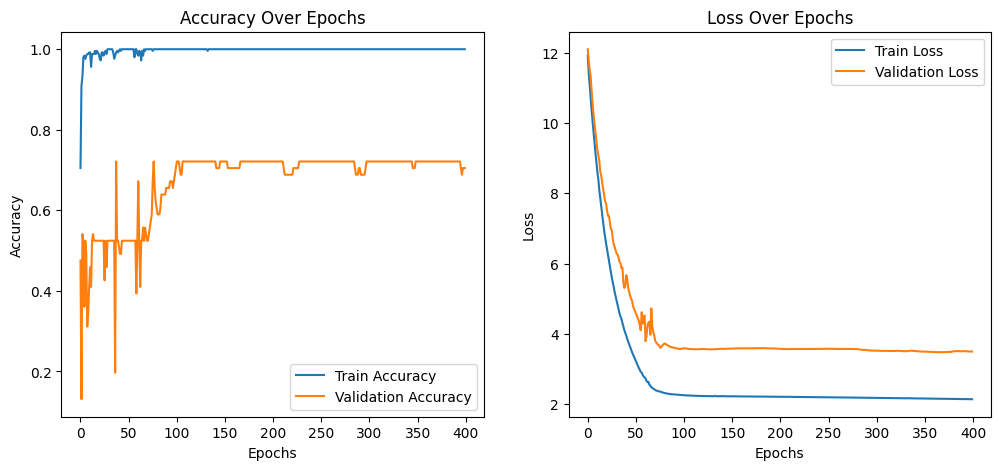

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, confusion_matrix

# 모델 학습 설정
batch_size = 32
epochs = 400

# 모델 학습
history = model.fit(
    X_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_test, y_test),
    callbacks=[reduce_lr]
)

# 모델 평가
test_loss, test_acc, test_auc = model.evaluate(X_test, y_test)
print(f"\n📊 테스트 결과:")
print(f"✅ 정확도 (Accuracy): {test_acc:.4f}")
print(f"✅ AUC: {test_auc:.4f}")
print(f"✅ 손실 (Loss): {test_loss:.4f}")

# 🔹 모델 예측 실행
y_pred_probs = model.predict(X_test)  # 확률값 출력
y_pred = (y_pred_probs >= 0.5).astype(int)  # 0.5 기준으로 이진 분류

# 🔹 추가 성능 지표 계산
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Confusion Matrix를 이용한 특이도(Specificity) 계산
cm = confusion_matrix(y_test, y_pred)
TN, FP, FN, TP = cm.ravel()  # TN, FP, FN, TP 추출
specificity = TN / (TN + FP) if (TN + FP) > 0 else 0  # 특이도 계산

print(f"✅ 재현율 (Recall): {recall:.4f}")
print(f"✅ 특이도 (Specificity): {specificity:.4f}")
print(f"✅ F1-score: {f1:.4f}")

# 🔹 학습 과정 시각화
plt.figure(figsize=(12, 5))

# 정확도 그래프
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy Over Epochs")

# 손실 그래프
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss Over Epochs")

plt.show()